## Task
**Find out weather person is merrid**. (*filed S2*)

It is first homework for [interpretable machine learning](https://github.com/pbiecek/InterpretableMachineLearning2018S/tree/master/PraceDomowe/PD1).
### Data
From a study [about relationships](https://flowingdata.com/2019/02/26/probability-you-will-break-up-with-your-partner/).
* [Project site and link to data](https://data.stanford.edu/hcmst2017)
* [Columns description](https://stacks.stanford.edu/file/druid:vt073cc9067/HCMST_2017_fresh_Codeboodk_v1.1a.pdf)

In [0]:
import pandas as pd
import numpy as np

In [187]:
!wget -O - 'http://stacks.stanford.edu/file/druid:hg921sg6829/HCMST_2017_public_data_v1.1_stata.zip' > HCMST.zip
!unzip HCMST.zip 
!mv 'HCMST 2017 fresh sample for public sharing draft v1.1.dta' HCMST.dta

URL transformed to HTTPS due to an HSTS policy
--2019-03-08 22:52:50--  https://stacks.stanford.edu/file/druid:hg921sg6829/HCMST_2017_public_data_v1.1_stata.zip
Resolving stacks.stanford.edu (stacks.stanford.edu)... 171.67.37.91
Connecting to stacks.stanford.edu (stacks.stanford.edu)|171.67.37.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 463647 (453K) [application/zip]
Saving to: ‘STDOUT’

-                   100%[===================>] 452.78K  2.22MB/s    in 0.2s    

2019-03-08 22:52:50 (2.22 MB/s) - written to stdout [463647/463647]

Archive:  HCMST.zip
  inflating: HCMST 2017 fresh sample for public sharing draft v1.1.dta  


In [0]:
raw_data = pd.read_stata('HCMST.dta')

In [189]:
selected_cols = {
    'ppage': 'age', 
    'ppincimp': 'hausehold_income', 
    'ppp20072': 'religion', 
#    'w6_how_many_2': 'different_partners_ly' -- only 2% filedes has not nan value
#    'Q32_2': 'meet_in_internet' -- only 15% data all in not-merried
    'Q25': 'same_high_school'
}
predict_col = {'S1': 'merried'}

data = raw_data[list(selected_cols.keys()) + list(predict_col.keys())]
data = data.rename(selected_cols, axis='columns')
data = data.rename(predict_col, axis='columns')

data.head()

#['partner age','are you same sex','partner education','age', 'Q27: How often do you attend religious services?', 'Did you and [Partner name] attend the same high school?', 'Same university/colage']
#['Q9', 'Q5', 'Q10', 'ppage', 'ppp20072', 'Q25', 'Q26']
# Q23 who earnd more in 2016
# ppgender gendeer

# Q32_2 Did you use an Internet service to meet [Partner name]? 
# w6_how_many_2 byte %8.0g V155_A
#  How many Different people have you met for dating, or romance, or sex in the pas
# w6_q19 byte %8.0g Q19 Are you currently living wit
# Q21A_2_Year Year you first met the partner

,age,hausehold_income,religion,same_high_school,merried
0,30,"$40,000 to $49,999",Never,NaN,"No, I am not Married"
1,55,"$150,000 to $174,999",Never,Different High School,"Yes, I am Married"
2,47,"$200,000 to $249,999",Once or twice a month,Different High School,"Yes, I am Married"
3,28,"$40,000 to $49,999",Never,NaN,"No, I am not Married"
4,59,"$175,000 to $199,999",Once a year or less,Different High School,"Yes, I am Married"


In [0]:
religion_cat = pd.api.types.CategoricalDtype(
    categories=['Never', 'Once a year or less', 'A few times a year',
                'Once or twice a month', 'Once a week', 'More than once a week'],
    ordered=True)

income_cat = pd.api.types.CategoricalDtype(
    categories=['Less than $5,000', '$5,000 to $7,499', '$7,500 to $9,999',
                '$10,000 to $12,499', '$12,500 to $14,999', '$15,000 to $19,999',
                '$20,000 to $24,999', '$25,000 to $29,999', '$30,000 to $34,999',
                '$35,000 to $39,999', '$40,000 to $49,999', '$50,000 to $59,999',
                '$60,000 to $74,999', '$75,000 to $84,999', '$85,000 to $99,999',
                '$100,000 to $124,999', '$125,000 to $149,999', '$150,000 to $174,999',
                '$175,000 to $199,999', '$200,000 to $249,999', '$250,000 or more'],
    ordered=True)

data['age'] = data['age'].astype('int')
#data['hausehold_income'] = data['hausehold_income'].astype(income_cat)
#data['religion'] = data['religion'].astype(religion_cat)

In [0]:
# średnia wartość w przedziale
income_conv = {
    'Less than $5,000': 2.5, 
    '$5,000 to $7,499': 6.25, 
    '$7,500 to $9,999': 8.75,
    '$10,000 to $12,499': 11.25, 
    '$12,500 to $14,999': 13.75, 
    '$15,000 to $19,999': 17.5,
    '$20,000 to $24,999': 22.5, 
    '$25,000 to $29,999': 27.5, 
    '$30,000 to $34,999': 32.5,
    '$35,000 to $39,999': 37.5, 
    '$40,000 to $49,999': 45, 
    '$50,000 to $59,999': 55,
    '$60,000 to $74,999': 67.5, 
    '$75,000 to $84,999': 80, 
    '$85,000 to $99,999': 92.5,
    '$100,000 to $124,999': 112.5, 
    '$125,000 to $149,999': 137.5, 
    '$150,000 to $174,999': 162.5,
    '$175,000 to $199,999': 182.5, 
    '$200,000 to $249,999': 225, 
    '$250,000 or more': 275,       # trudno znaleźć wartość między nieskończonością
}

religion_conv = { religion_cat.categories[i]: i for i in range(len(religion_cat.categories)) }

high_school_conv = { 
    'Same High School': 1, 
    'Different High School': 0    
}

merried_conv = {
    'No, I am not Married': 0,
    'Yes, I am Married': 1
}


In [192]:
data.head()

,age,hausehold_income,religion,same_high_school,merried
0,30,"$40,000 to $49,999",Never,NaN,"No, I am not Married"
1,55,"$150,000 to $174,999",Never,Different High School,"Yes, I am Married"
2,47,"$200,000 to $249,999",Once or twice a month,Different High School,"Yes, I am Married"
3,28,"$40,000 to $49,999",Never,NaN,"No, I am not Married"
4,59,"$175,000 to $199,999",Once a year or less,Different High School,"Yes, I am Married"


In [193]:
for (name, m) in (('religion', religion_conv), 
                  ('same_high_school', high_school_conv),
                  ('hausehold_income', income_conv),
                  ('merried', merried_conv),):
    data[name + '_val'] = data[name].map(m)

data.head()

,age,hausehold_income,religion,same_high_school,merried,religion_val,same_high_school_val,hausehold_income_val,merried_val
0,30,"$40,000 to $49,999",Never,NaN,"No, I am not Married",0.0,NaN,45.0,0
1,55,"$150,000 to $174,999",Never,Different High School,"Yes, I am Married",0.0,0.0,162.5,1
2,47,"$200,000 to $249,999",Once or twice a month,Different High School,"Yes, I am Married",3.0,0.0,225.0,1
3,28,"$40,000 to $49,999",Never,NaN,"No, I am not Married",0.0,NaN,45.0,0
4,59,"$175,000 to $199,999",Once a year or less,Different High School,"Yes, I am Married",1.0,0.0,182.5,1


In [194]:
use_columns, predict_columns = (['age', 'hausehold_income_val', 'religion_val', 'same_high_school_val'], ['merried_val'])

data.dtypes

age                        int64
hausehold_income        category
religion                category
same_high_school        category
merried                 category
religion_val             float64
same_high_school_val     float64
hausehold_income_val     float64
merried_val                int64
dtype: object

In [195]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data[use_columns + predict_columns].fillna(-1), test_size=0.2)
test.head()

,age,hausehold_income_val,religion_val,same_high_school_val,merried_val
2123,27,32.5,4.0,0.0,1
766,74,92.5,2.0,0.0,1
1187,26,27.5,0.0,-1.0,0
2222,59,55.0,3.0,0.0,1
2300,45,67.5,2.0,0.0,1


In [0]:
train_X = train[use_columns]
train_y = train[predict_columns]
test_X = test[use_columns]
test_y = test[predict_columns]

In [0]:
from sklearn import tree

model = tree.DecisionTreeClassifier(max_depth=7)
trained = model.fit(train_X, train_y)
#model = tree.fit(train_X, train_Y)

In [263]:
trained.score(test_X, test_y)

0.801994301994302

In [250]:
# Wybrana osoba:

index = 2123
test_X.head(1)

,age,hausehold_income_val,religion_val,same_high_school_val
2123,27,32.5,4.0,0.0


In [251]:
person = data.loc[index]
parsed_person = data.loc[index][use_columns].copy()
person

age                                        27
hausehold_income           $30,000 to $34,999
religion                          Once a week
same_high_school        Different High School
merried                     Yes, I am Married
religion_val                                4
same_high_school_val                        0
hausehold_income_val                     32.5
merried_val                                 1
Name: 2123, dtype: object

In [0]:
def predict_with_changed(column, values):
    
    spectrum = []
    for i in range(len(values)):
        obj = parsed_person.copy();
        obj[column] = values[i]
        spectrum.append(obj)
    return trained.predict_proba(spectrum)

In [244]:
trained.score([parsed_person],[[0]])

1.0

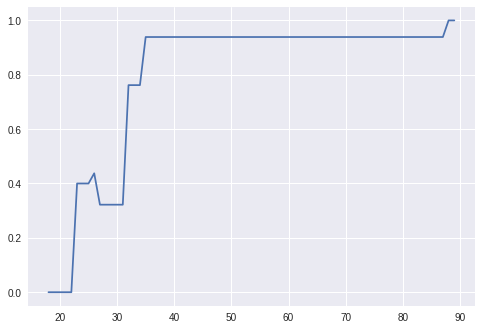

In [268]:
import matplotlib.pyplot as plt

age_spectrum = predict_with_changed('age', range(18, 90)) #= np.c_[[[i] for i in range(18,90)], predict_with_changed('age', range(18, 90))]
plt.plot(range(18,90), age_spectrum[:,1])

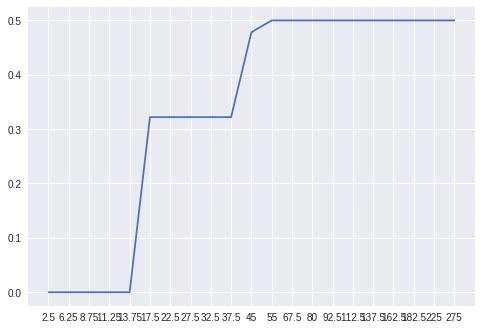

In [269]:
income_spectrum = predict_with_changed('hausehold_income_val', list(income_conv.values()))
plt.plot(list(map(str,income_conv.values())), income_spectrum[:,1])

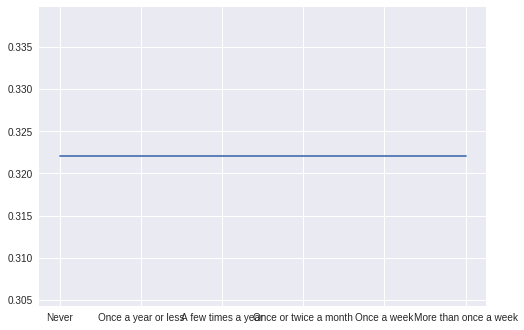

In [270]:
religion_spectrum = predict_with_changed('religion_val', list(religion_conv.values()))
plt.plot(list(religion_conv.keys()), religion_spectrum[:,1])

In [272]:
hs_predictions = predict_with_changed('same_high_school_val',[0,1])
print("Different high school: " + str(hs_predictions[0][1]))
print("Same high school: " + str(hs_predictions[1][1]))

Different high school: 0.3220338983050847
Same high school: 0.3220338983050847
